In [332]:
# reading in the data:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/creditcard_sample.csv")
df.head()


train, test = train_test_split(df, test_size=0.2)

x_rows = ["Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount"]
y_row = "Class"

train_x = train[x_rows]
train_y = train[y_row]

test_x = test[x_rows]
test_y = test[y_row]


# Classical classification methods

- Logistic regression (LR)
- support vector machine (SVM)
- random forest (RF)


In [99]:
# logistic regression
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter = 3000)
reg.fit(train_x, train_y)
test_y_pred_log_reg = reg.predict(test_x) 

In [89]:
# support vector machine
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm.fit(train_x, train_y)
test_y_pred_svm = svm.predict(test_x) 


In [90]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(train_x, train_y)
test_y_pred_rfc = rfc.predict(test_x) 


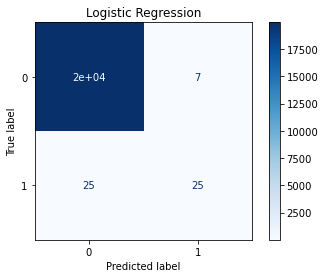

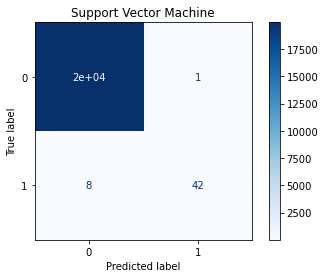

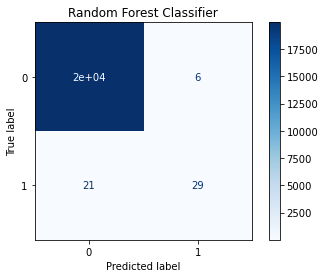

In [257]:
from sklearn.metrics import confusion_matrix as confusion_matrix_bad_impl, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


def confusion_matrix(y_true, y_pred):
    # is bad because does not always give 2x2 array as output
    c = confusion_matrix_bad_impl(y_true, y_pred)
    if(len(c) == 1):
        val = c[0][0]
        a = np.array([[0,0],[0,0]])
        if y_true[0]:
            a[1,1] = val
            return a
        else:
            a[0,0] = val
            return a
    return np.array(c)

def plot_confusion_matrix(true,predicted, title=""):
    d = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true, predicted))
    d.plot(cmap="Blues")
    plt.title(title)
    plt.show()

def plot_confusion_matrix_from_matrix(confusion_matrix, title=""):
    d = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    d.plot(cmap="Blues")
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_y, reg.predict(test_x), title="Logistic Regression")

plot_confusion_matrix(test_y, svm.predict(test_x), title="Support Vector Machine")

plot_confusion_matrix(test_y, rfc.predict(test_x), title="Random Forest Classifier")

In [105]:
def acc_prec_rec_f1(true_labels, predicted_labels):
    c = confusion_matrix(true_labels, predicted_labels)
    tn = c[0,0]
    tp = c[1,1]
    fp = c[0,1]
    fn = c[1,0]
    acc = (tp+tn)/(tn + tp + fp + fn)
    prec = tp/(tp+fp)
    rec = tp / (fn + tp)
    f1 = 2 * prec * rec /(prec + rec)
    return acc, prec,rec, f1

tmpl = "{}: \nAccuracy: {}\nPrecision: {}\nRecall: {}\nF1: {}\n"

print(tmpl.format("Logistic Regression", *acc_prec_rec_f1(test_y, test_y_pred_log_reg)))
print(tmpl.format("Support Vector Machine", *acc_prec_rec_f1(test_y, test_y_pred_svm)))
print(tmpl.format("Random Forest Classifier", *acc_prec_rec_f1(test_y, test_y_pred_rfc)))


Logistic Regression: 
Accuracy: 0.99875
Precision: 0.75
Recall: 0.42857142857142855
F1: 0.5454545454545454

Support Vector Machine: 
Accuracy: 0.9994
Precision: 1.0
Recall: 0.6571428571428571
F1: 0.7931034482758621

Random Forest Classifier: 
Accuracy: 0.99895
Precision: 0.7916666666666666
Recall: 0.5428571428571428
F1: 0.6440677966101694



In [208]:
# DNN definition
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


def create_binary_classification_model(input_layer_size = 30, hidden_layers = 2, hidden_layer_size = 10) -> nn.Sequential:
    layers = [
        ("hidden_layer_1", nn.Linear(input_layer_size, hidden_layer_size)),
        ("activation_1", nn.ReLU())        
    ]
   
    for i in range(2, hidden_layers+1):
        layers.append((f"hidden_layer_{i}",nn.Linear(hidden_layer_size, hidden_layer_size) ))
        layers.append((f"activation_{i}",  nn.ReLU()))

    layers.append(("output_layer", nn.Linear(hidden_layer_size, 1)) )
    layers.append(("softmax", nn.Sigmoid()))
    return nn.Sequential(OrderedDict(layers))

def batch_iterator(xes, y, batch_size):
    for i in range(0, xes.shape[0], batch_size):
        yield (xes[i:i + batch_size], y[i:i + batch_size])


In [188]:
# create training and test data for torch
torch_train_x = torch.from_numpy(train_x.to_numpy()).float()
torch_test_x = torch.from_numpy(test_x.to_numpy()).float()
torch_train_y = torch.from_numpy(train_y.to_numpy()).unsqueeze(1).float()
torch_test_y = torch.from_numpy(test_y.to_numpy()).unsqueeze(1).float()

print(torch_train_x.size())
print(torch_train_y.size())
print(torch_test_x.size())
print(torch_test_y.size())

torch.Size([79999, 30])
torch.Size([79999, 1])
torch.Size([20000, 30])
torch.Size([20000, 1])


In [328]:
import typing
import sklearn

from torchmetrics import Accuracy


def confusion_matrix_to_accuracy(confusion):
    return (confusion[0,0] +  confusion[1,1]) / confusion_matrix_to_sample_count(confusion)

def confusion_matrix_to_sample_count(confusion):
    return confusion[0,0] +  confusion[0,1] +  confusion[1,0] +  confusion[1,0]

accuracy = Accuracy()

def determine_device():
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    return DEVICE

class TrainSettings:
    EPOCHS = 4
    BATCH_SIZE = 64
    LR = 0.001
    LOSS_FUNCTION = nn.BCELoss()
    DEVICE = determine_device()

    def __init__(self, EPOCHS = 4, BATCH_SIZE = 64, LR = 0.001, LOSS_FUNCTION=nn.BCELoss(), ) -> None:
        self.DEVICE = determine_device()
        self.EPOCHS = EPOCHS
        self.BATCH_SIZE = BATCH_SIZE
        self.LR = LR
        self.LOSS_FUNCTION = LOSS_FUNCTION

class EpochStats:
    train_loss: float
    test_loss: float
    epoch: int
    def __init__(self,epoch, train_loss, train_conf, test_loss, test_conf) -> None:
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.train_confusion = train_conf
        self.test_confusion = test_conf

class TrainStats:
    train_settings: TrainSettings
    epochs: typing.List[EpochStats]
    
    # def add_epoch(train_loss)
    def __init__(self, train_settings) -> None:
        self.train_settings = train_settings
        self.epochs = []

    def add_epoch(self, epoch_stats: EpochStats):
        self.epochs.append(epoch_stats)

    def visualize_loss(self):
        x = [e.epoch for e in self.epochs]
        plt.plot(x, [e.train_loss for e in self.epochs], label = "Train Loss")
        plt.plot(x, [e.test_loss for e in self.epochs], label = "Test Loss")
        plt.legend()
        plt.title("Blablababa")
        plt.xlabel("Epoch")
        plt.xlabel("Loss") 
        plt.show()  

    def visualize_accuracy(self):
        x = [e.epoch for e in self.epochs]
        plt.plot(x, [confusion_matrix_to_accuracy(e.test_confusion) for e in self.epochs], label = "Train Accuracy")
        plt.plot(x, [confusion_matrix_to_accuracy(e.train_confusion) for e in self.epochs], label = "Test Accuracy")
        plt.legend()
        plt.title("Blablababa")
        plt.xlabel("Epoch")
        plt.xlabel("Accuracy")
        plt.show()

    def plot_confusion_matrizes(self):
        plot_confusion_matrix_from_matrix(self.epochs[len(self.epochs)-1].test_confusion, "Test Confusion")
        plot_confusion_matrix_from_matrix(self.epochs[len(self.epochs)-1].train_confusion, "Train Confusion")



In [314]:
# training function to turn a model into a trained network
from typing import Tuple


trainTemplate = "epoch: {} test loss: {:.3f} test accuracy: {:.3f}"
testTemplate = "epoch: {} test loss: {:.3f} test accuracy: {:.3f}"


def train_network_from_model(model, train_x, train_y, test_x, test_y, train_settings: TrainSettings = TrainSettings()) ->  Tuple[nn.Sequential,TrainStats] :
    print(f"using {train_settings.DEVICE} for training, EPOCHS={train_settings.EPOCHS}, BATCH_SIZE={train_settings.BATCH_SIZE}, LR={train_settings.LR}")
    
    network = model.to(train_settings.DEVICE)
    optimizer = Adam(network.parameters(), lr=train_settings.LR)
    train_stats = TrainStats(train_settings)
    for epoch in range(1, train_settings.EPOCHS+1):
        print(f"EPOCH {epoch}:")
        train_loss, train_conf = train_network(network, optimizer, train_x, train_y, train_settings)
        test_loss, test_conf = evaluate_network(network, test_x, test_y, train_settings)
        train_stats.add_epoch(EpochStats(epoch, train_loss, train_conf, test_loss, test_conf))
        
    return (network, train_stats)

def train_network(network, optimizer, train_x, train_y, train_settings: TrainSettings):
    loss, conf = 0, [[0,0],[0,0]]
    network.train()
    for (bx,by) in batch_iterator(train_x, train_y, train_settings.BATCH_SIZE):
        l, c = train_network_on_batch(network, optimizer, bx,by, train_settings)
        loss += l * confusion_matrix_to_sample_count(c)
        conf += c
    loss = loss / confusion_matrix_to_sample_count(conf)
    acc = confusion_matrix_to_accuracy(conf)
    print("TRAIN: train loss: {:.5f} train accuracy: {:.5f}".format(loss,
            acc))
    return loss, conf

def train_network_on_batch(network, optimizer, bx,by,train_settings: TrainSettings):
    pred = network(bx)
    loss = train_settings.LOSS_FUNCTION(pred, by.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss = loss.item()
    conf = confusion_matrix(by == 1, pred > 0.5)
    return loss, conf

def evaluate_network(network, test_x, test_y, train_settings):
    network.eval() # activate eval mode
    # initialize a no-gradient context
    with torch.no_grad():
        # loop over the current batch of test data
        (test_x_1, test_y_1) = (test_x.to(train_settings.DEVICE), test_y.to(train_settings.DEVICE))
        predictions = network(test_x_1).float()   
        loss = train_settings.LOSS_FUNCTION(predictions, test_y_1.float())
        conf = confusion_matrix(test_y_1 == 1, predictions > 0.5)
        acc = confusion_matrix_to_accuracy(conf)
        print("EVAL: test loss: {:.5f} test accuracy: {:.5f}".format(loss, acc))
        return loss, conf 




In [330]:
# how to create and train a model now (example)
model = create_binary_classification_model(30, 6, 8)
train_settings = TrainSettings(EPOCHS=20)

net, stats = train_network_from_model(model, torch_train_x, torch_train_y, torch_test_x, torch_test_y, train_settings)


using cpu for training, EPOCHS=20, BATCH_SIZE=64, LR=0.001
EPOCH 1:
TRAIN: train loss: 0.10213 train accuracy: 0.97606
EVAL: test loss: 0.02973 test accuracy: 0.99501
EPOCH 2:
TRAIN: train loss: 0.01814 train accuracy: 0.99568
EVAL: test loss: 0.01890 test accuracy: 0.99501
EPOCH 3:
TRAIN: train loss: 0.01601 train accuracy: 0.99568
EVAL: test loss: 0.01817 test accuracy: 0.99501
EPOCH 4:
TRAIN: train loss: 0.01609 train accuracy: 0.99568
EVAL: test loss: 0.01856 test accuracy: 0.99501
EPOCH 5:
TRAIN: train loss: 0.01588 train accuracy: 0.99568
EVAL: test loss: 0.01806 test accuracy: 0.99501
EPOCH 6:
TRAIN: train loss: 0.01573 train accuracy: 0.99568
EVAL: test loss: 0.01763 test accuracy: 0.99501
EPOCH 7:
TRAIN: train loss: 0.01565 train accuracy: 0.99568
EVAL: test loss: 0.01756 test accuracy: 0.99501
EPOCH 8:
TRAIN: train loss: 0.01560 train accuracy: 0.99568
EVAL: test loss: 0.01746 test accuracy: 0.99501
EPOCH 9:
TRAIN: train loss: 0.01555 train accuracy: 0.99568
EVAL: test loss: 

EVAL: test loss: 0.01725 test accuracy: 0.99501


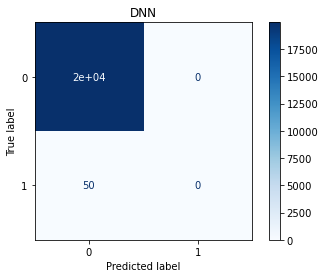

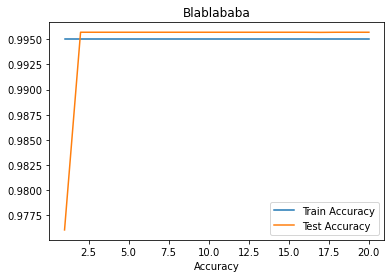

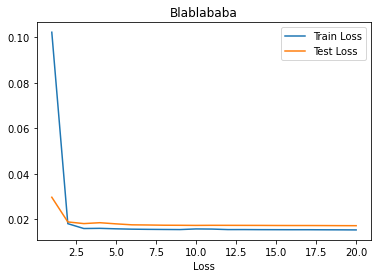

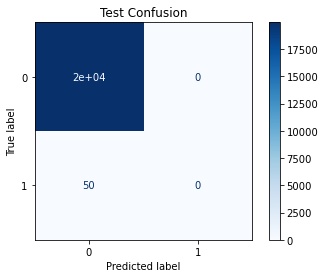

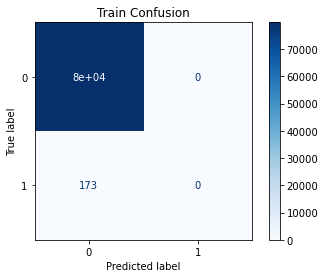

In [331]:
loss, confusion =evaluate_network(net, torch_test_x, torch_test_y, train_settings)
plot_confusion_matrix_from_matrix(confusion, title="DNN")


# print(confusion[0,1])
# # stats.visualize_loss()
stats.visualize_accuracy()
plt.show()
stats.visualize_loss()

stats.plot_confusion_matrizes()
